# TripAdvisor Review Modeling
#### Calibration • Confidence Intervals • Calibrated SVM • Baseline Recommender

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
print('\nShape:', df.shape)
print('\nColumns:', df.columns.tolist())


Shape: (20491, 2)

Columns: ['Review', 'Rating']


In [3]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## Data Preprocessing
We’ll assume the dataset has at least the following columns:
- `Review` → Text content
- `Rating` → Numeric rating (1–5)

We’ll create a binary sentiment label: **1 = Positive (rating > 3), 0 = Negative (≤3)**.

In [3]:
df = df.rename(columns={c: c.strip().title() for c in df.columns})
if 'Review' not in df.columns:
    df.columns = ['Review', 'Rating'] + list(df.columns[2:])

df['Sentiment'] = (df['Rating'] > 3).astype(int)
print(df['Sentiment'].value_counts())

Sentiment
1    15093
0     5398
Name: count, dtype: int64


## Text Vectorization (TF-IDF) + Calibrated SVM Model

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    df['Review'], df['Sentiment'], test_size=0.2, stratify=df['Sentiment'], random_state=42
)

# Build the pipeline
calibrated_svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    # no explicit scaler needed here because TF-IDF is already normalized
    ('calibrated_svm', CalibratedClassifierCV(
        estimator=LinearSVC(),
        method='sigmoid',  # Platt scaling
        cv=3
    ))
])

print("Training Calibrated Linear SVM...")
calibrated_svm_pipeline.fit(X_train, y_train)

Training Calibrated Linear SVM...


,steps,"[('tfidf', ...), ('calibrated_svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [5]:
# Evaluate
y_pred_proba = calibrated_svm_pipeline.predict_proba(X_val)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_pred_proba)
f1 = f1_score(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)
brier = brier_score_loss(y_val, y_pred_proba)

print(f"AUC: {auc:.4f} | F1: {f1:.4f} | Acc: {acc:.4f} | Brier: {brier:.4f}")

AUC: 0.9491 | F1: 0.9356 | Acc: 0.9034 | Brier: 0.0723


In [6]:
import pickle
with open('outputs/calibrated_svm.pkl', 'wb') as file:
    pickle.dump(calibrated_svm_pipeline, file)

In [7]:
# Optional: Bootstrap confidence interval for AUC
n_boots = 100
boot_aucs = []
rng = np.random.default_rng(42)

for _ in range(n_boots):
    idx = rng.choice(len(y_val), len(y_val), replace=True)
    boot_aucs.append(roc_auc_score(y_val.iloc[idx], y_pred_proba[idx]))

ci_lower, ci_upper = np.percentile(boot_aucs, [2.5, 97.5])
print(f"AUC 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

AUC 95% CI: [0.9439, 0.9567]


## Calibration Curve Visualization

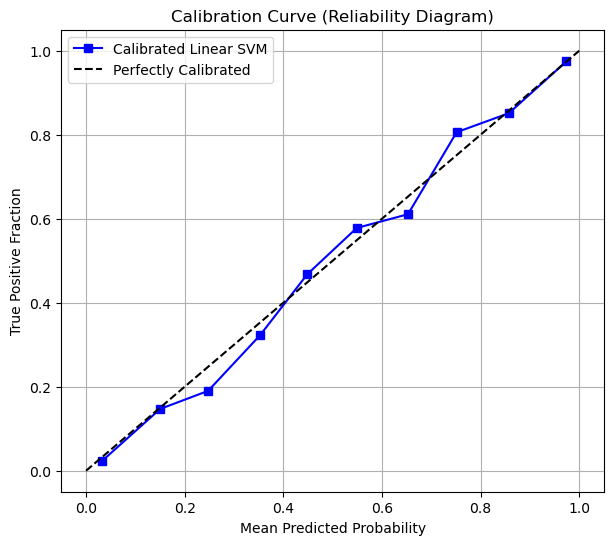

In [8]:
# Compute calibration data
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=10)

plt.figure(figsize=(7, 6))

# Calibration line
plt.plot(prob_pred, prob_true, "s-", label="Calibrated Linear SVM", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")

# Formatting
plt.title("Calibration Curve (Reliability Diagram)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("True Positive Fraction")
plt.legend()
plt.grid(True)
plt.show()

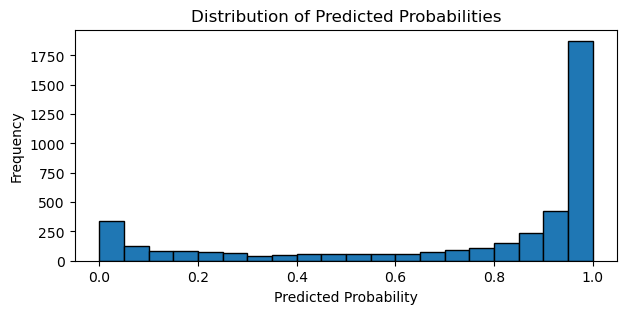

In [9]:
plt.figure(figsize=(7, 3))
plt.hist(y_pred_proba, bins=20, range=(0,1), edgecolor='black')
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

## SHAP Explainability 

In [10]:
from sklearn.linear_model import LogisticRegression

# Extract TF-IDF features from validation set 
tfidf = calibrated_svm_pipeline.named_steps['tfidf']
X_val_tfidf = tfidf.transform(X_val)
feature_names = tfidf.get_feature_names_out()

# Train a lightweight interpretable model for SHAP 
logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(tfidf.transform(X_train), y_train)

# Use LinearExplainer with logistic model 
explainer = shap.LinearExplainer(
    logit_model,
    X_val_tfidf,
    feature_perturbation="interventional"
)

# Compute SHAP values 
X_sample = X_val_tfidf[:100]
shap_values = explainer.shap_values(X_sample)

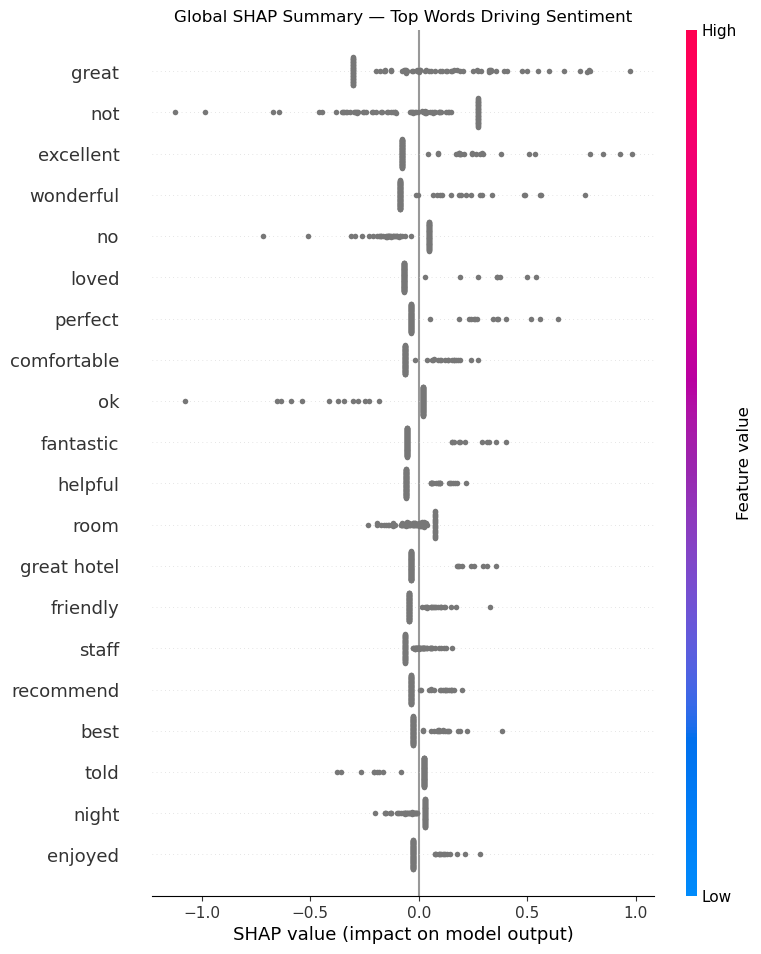

In [11]:
shap.summary_plot(shap_values, features=X_sample, feature_names=feature_names, show=False)
plt.title("Global SHAP Summary — Top Words Driving Sentiment")
plt.show()

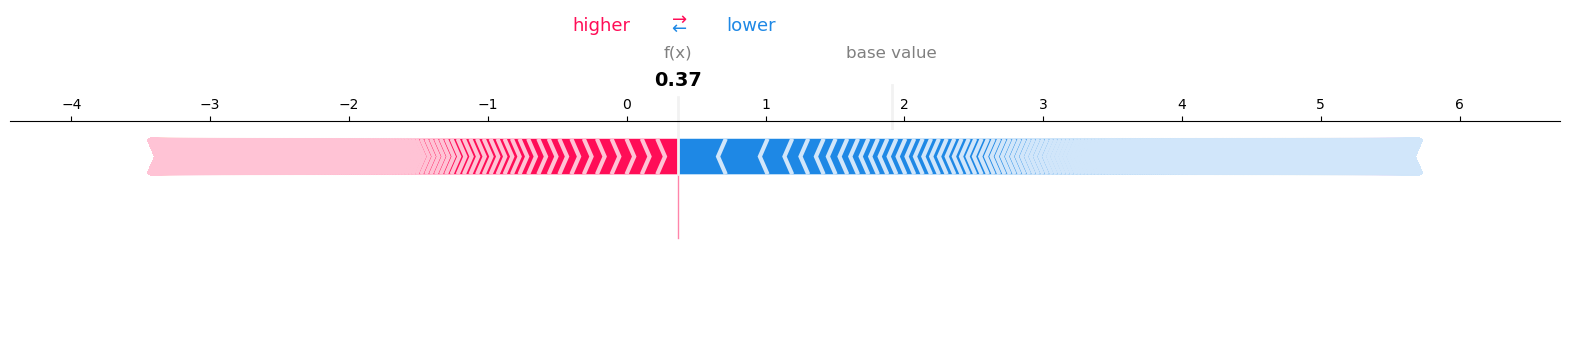

In [12]:
# Example 

sample_idx = 0
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    feature_names=feature_names,
    matplotlib=True
)

## Baseline Recommender (Popularity)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# Extract TF-IDF matrix from your calibrated SVM pipeline
tfidf_vectorizer = calibrated_svm_pipeline.named_steps['tfidf']
tfidf_matrix = tfidf_vectorizer.transform(df['Review'])

from sklearn.preprocessing import normalize
tfidf_matrix = normalize(tfidf_matrix)


def recommend_similar_reviews(index, n=5):
    """
    Recommend 'n' reviews most similar to the given review index.
    Works on-demand using cosine similarity (no huge precomputed matrix).
    """
    query_vec = tfidf_matrix[index]
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    # get top n indices excluding itself
    top_indices = similarities.argsort()[-n-1:-1][::-1]
    return df.iloc[top_indices][['Review', 'Sentiment']]

In [14]:
# Example usage: pick one review and find 5 similar ones

sample_index = 19  # change this index to test other reviews
print("Original Review:")
print(df.loc[sample_index, 'Review'])
print("\nTop 5 Similar Reviews:")
display(recommend_similar_reviews(sample_index, n=5))

Original Review:
hmmmmm say really high hopes hotel monaco chose base girlfriend shopping trip seattle, stay say given competition seattle just okay, hotel lot nice features little things detract bedding super soft luxurious comforters pillows, mattress rock hard standard hotel bed kept awake nights, furnishings nice colors patterns fun chair rip wall paper peeling, stayed room 815 noise like fog horn vibrated walls stay, guess water pipes really annoying.on waking morning packages decaf instead regular coffee, took 30 minutes send coffee showed just package, coffee town usa little package 3 tiny dried creamers, supposed coffee service lobby saw, cleared really early, gone 10am, wine reception 5-6 boy better time walk 5:50 like did look manager like trying scope 2nd glass, food plate goldfish crackers, classy.friday night restaurant bar closed 4pm private party, planned eat heard fun bar, bummer add rest.all hotel posters say things like hotel comfort, felt catered comfortable, no staf

,Review,Sentiment
374,"good hotel deal rack rates hotel 250-350, pric...",1
7951,excellent hotel little gaffs just spent 4 nigh...,1
3,"unique, great stay, wonderful time hotel monac...",1
15055,"okay..need communication pls, overall just oka...",0
441,"amazing staff small cute, say friendliest hote...",1


In [15]:
import joblib
import os

# # Make sure these directories exist
# os.makedirs("data/processed", exist_ok=True)
# os.makedirs("outputs", exist_ok=True)
# os.makedirs("src/models", exist_ok=True)

try:
    df.to_csv("tripadvisor_clean.csv", index=False)
    # print("Saved cleaned dataset → data/processed/tripadvisor_clean.csv")
except Exception as e:
    print(f"Could not save dataset: {e}")

try:
    joblib.dump(calibrated_svm_pipeline, "tripadvisor_calibrated_pipeline.joblib")
    # print("Saved calibrated SVM pipeline → outputs/tripadvisor_calibrated_pipeline.joblib")
except Exception as e:
    print(f"Could not save pipeline: {e}")

try:
    import scipy.sparse
    scipy.sparse.save_npz("tfidf_matrix.npz", tfidf_matrix)
    # print("Saved TF-IDF matrix → outputs/tfidf_matrix.npz")
except Exception as e:
    print(f" Could not save TF-IDF matrix (may be too large): {e}")

recommender_code = '''
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar_reviews(index, df, tfidf_matrix, n=5):
    """
    Recommend top-n reviews most similar to a given review index.
    Parameters:
        index (int): Index of the review to find similarities for.
        df (pd.DataFrame): DataFrame containing the 'Review' and 'Sentiment' columns.
        tfidf_matrix (sparse matrix): TF-IDF feature matrix.
        n (int): Number of recommendations to return.
    """
    query_vec = tfidf_matrix[index]
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = similarities.argsort()[-n-1:-1][::-1]
    return df.iloc[top_indices][["Review", "Sentiment"]]
'''

with open("recommender.py", "w", encoding="utf-8") as f:
    f.write(recommender_code)

print("Saved recommender helper → src/models/recommender.py")

print("\n All TripAdvisor artifacts saved successfully!")


Saved recommender helper → src/models/recommender.py

 All TripAdvisor artifacts saved successfully!
